# Mushroom Edibility Classification Using Machine Learning

In [22]:
pip install xgboost

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
    --------------------------------------- 1.0/72.0 MB 7.1 MB/s eta 0:00:10
   -- ------------------------------------- 4.7/72.0 MB 13.3 MB/s eta 0:00:06
   ----- ---------------------------------- 9.2/72.0 MB 19.2 MB/s eta 0:00:04
   --------- ------------------------------ 17.3/72.0 MB 22.4 MB/s eta 0:00:03
   ------------- -------------------------- 23.6/72.0 MB 24.3 MB/s eta 0:00:02
   --------------- ------------------------ 28.0/72.0 MB 23.4 MB/s eta 0:00:02
   ------------------ --------------------- 32.8/72.0 MB 23.4 MB/s eta 0:00:02
   --------------------- ------------------ 38.3/72.0 MB 23.7 MB/s eta 0:00:02
   ------------------------ --------------- 43.3/72.0 MB 23.6 MB/s eta 0:00:02
   -------------------------- ------------- 48.2/72.0 MB 23.7 MB/s eta 0:00:02
   ----------------------------- ---------- 53.2/72.0 MB 23.7 MB/s eta 0:0

# Imports

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve
)


# Data Loading and EDA

In [61]:
df=pd.read_csv("secondary_data_shuffled.csv", sep =";")
df.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,e,1.72,x,s,y,f,d,NaN,w,7.01,...,NaN,t,y,NaN,NaN,f,f,NaN,h,u
1,e,9.59,f,e,b,f,NaN,c,b,4.73,...,NaN,NaN,w,NaN,NaN,t,f,NaN,d,a
2,p,0.86,x,g,p,f,a,NaN,p,4.25,...,NaN,s,k,NaN,NaN,f,f,NaN,d,s
3,p,4.32,x,NaN,e,f,x,NaN,w,4.91,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,e,2.80,x,s,w,f,d,d,w,3.13,...,NaN,NaN,w,NaN,NaN,f,f,NaN,m,a


In [3]:
df["class"].value_counts()

class
p    33888
e    27181
Name: count, dtype: int64

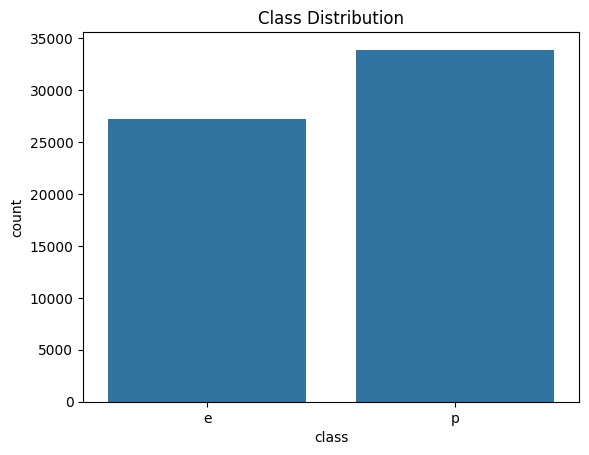

In [4]:
sns.countplot(x='class', data=df)
plt.title("Class Distribution")
plt.show()


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

In [6]:
df.describe()

,cap-diameter,stem-height,stem-width
count,61069.000000,61069.000000,61069.000000
mean,6.733854,6.581538,12.149410
std,5.264845,3.370017,10.035955
min,0.380000,0.000000,0.000000
25%,3.480000,4.640000,5.210000
50%,5.860000,5.950000,10.190000
75%,8.540000,7.740000,16.570000
max,62.340000,33.920000,103.910000


In [7]:
df.shape

(61069, 21)

In [8]:
missing_percent = df.isnull().mean().sort_values(ascending=False) * 100
missing_percent


veil-type               94.797688
spore-print-color       89.595376
veil-color              87.861272
stem-root               84.393064
stem-surface            62.427746
gill-spacing            41.040462
cap-surface             23.121387
gill-attachment         16.184971
ring-type                4.046243
cap-color                0.000000
cap-shape                0.000000
cap-diameter             0.000000
class                    0.000000
stem-height              0.000000
stem-width               0.000000
does-bruise-or-bleed     0.000000
gill-color               0.000000
has-ring                 0.000000
stem-color               0.000000
habitat                  0.000000
season                   0.000000
dtype: float64

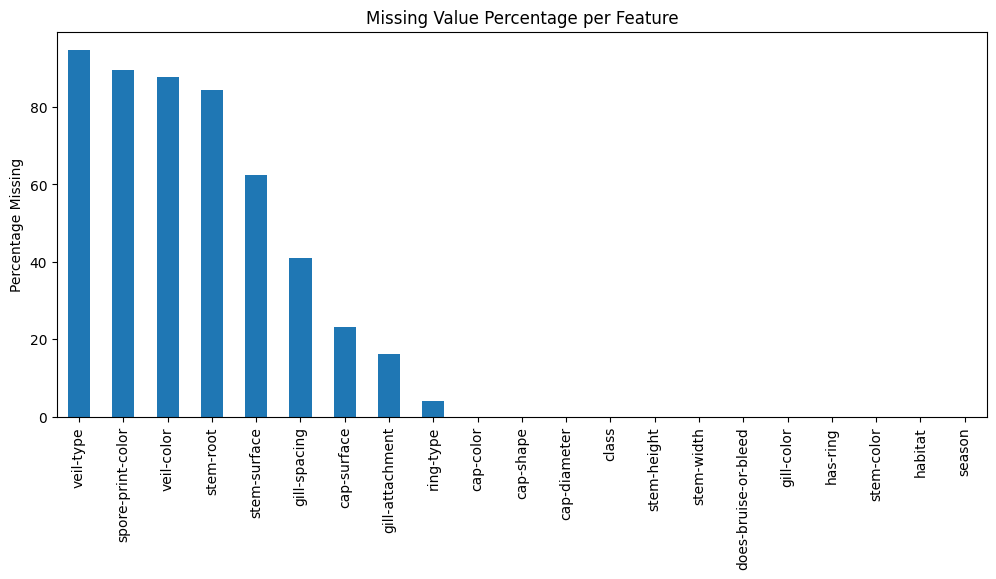

In [9]:
missing_percent.plot(kind='bar', figsize=(12,5))
plt.ylabel("Percentage Missing")
plt.title("Missing Value Percentage per Feature")
plt.show()


# Mapping target to 0 and 1

In [10]:
X = df.drop(columns=['class'])
y = df['class'].map({'e': 0, 'p': 1})

In [11]:
numeric_features = X.select_dtypes(include="float64").columns
categorical_features = X.select_dtypes(include="object").columns

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

Numeric features: Index(['cap-diameter', 'stem-height', 'stem-width'], dtype='object')
Categorical features: Index(['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed',
       'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root',
       'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring',
       'ring-type', 'spore-print-color', 'habitat', 'season'],
      dtype='object')


# Helper function for model evaluation

In [24]:
def evaluate_model(model, X, y, title):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]

    print(title)
    print(classification_report(y, y_pred))
    print("ROC-AUC:", roc_auc_score(y, y_prob))

    ConfusionMatrixDisplay.from_predictions(y, y_pred)
    plt.title(f"{title} - Confusion Matrix")
    plt.show()

    fpr, tpr, _ = roc_curve(y, y_prob)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y, y_prob):.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title} - ROC Curve")
    plt.legend()
    plt.show()


# Preprocessing

In [12]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


# Data Splitting

In [18]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

X_train_final = pd.concat([X_train, X_val], axis=0)
y_train_final = pd.concat([y_train, y_val], axis=0)

print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))
print(y_val.value_counts(normalize=True))

class
1    0.554903
0    0.445097
Name: proportion, dtype: float64
class
1    0.554961
0    0.445039
Name: proportion, dtype: float64
class
1    0.554913
0    0.445087
Name: proportion, dtype: float64


# Logistic Regression Training

In [14]:
logreg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1,
        solver="saga"
    ))
])

logreg_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['cap-diameter', 'stem-height', 'stem-width'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handl...
                                                  Index(['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed',
       'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root',
       'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring',
       'ring-type', 'spore-print-color', 'habitat', 'season'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    n_jobs=-1, solver='saga'))])

# Finding best parameters

In [15]:
lr_param_grid = {
    "classifier__C": [0.01, 0.1, 1, 10],
    "classifier__penalty": ["l1", "l2"]
}

grid_lr = GridSearchCV(
    logreg_model,
    lr_param_grid,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)
print("Best Logistic Regression Params:")
print(grid_lr.best_params_)


Best Logistic Regression Params:
{'classifier__C': 10, 'classifier__penalty': 'l1'}


In [16]:
best_C = grid_lr.best_params_["classifier__C"]
best_penalty = grid_lr.best_params_["classifier__penalty"]

In [19]:
final_lr_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        C=best_C,
        penalty=best_penalty,
        solver="liblinear",
        max_iter=1000,
        random_state=42
    ))
])

final_lr_pipeline.fit(X_train_final, y_train_final)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['cap-diameter', 'stem-height', 'stem-width'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handl...
                                                  Index(['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed',
       'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root',
       'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring',
       'ring-type', 'spore-print-color', 'habitat', 'season'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(C=10, max_iter=1000, penalty='l1',
                                    random_state=42, solver='liblinear'))])

In [20]:
lr_test_pred = final_lr_pipeline.predict(X_test)
lr_test_prob = final_lr_pipeline.predict_proba(X_test)[:, 1]

print("Logistic Regression - Final Test")
print(classification_report(y_test, lr_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, lr_test_prob))

Logistic Regression - Final Test
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4077
           1       0.88      0.88      0.88      5084

    accuracy                           0.87      9161
   macro avg       0.87      0.87      0.87      9161
weighted avg       0.87      0.87      0.87      9161

ROC-AUC: 0.9386008459885211


In [21]:
import joblib
joblib.dump(final_lr_pipeline, "final_logistic_model.pkl")

['final_logistic_model.pkl']

Logistic Regression (Validation)
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      4077
           1       0.91      0.86      0.88      5083

    accuracy                           0.87      9160
   macro avg       0.87      0.87      0.87      9160
weighted avg       0.87      0.87      0.87      9160

ROC-AUC: 0.9415867798855891


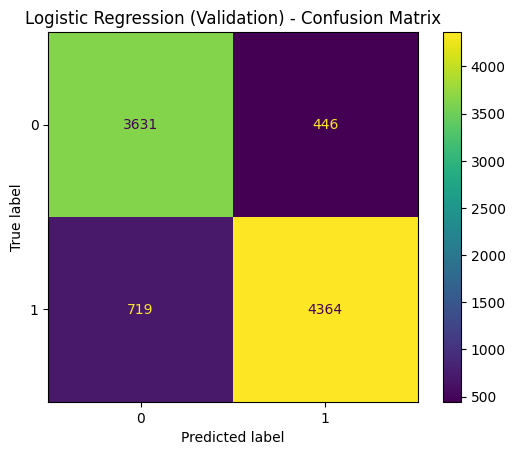

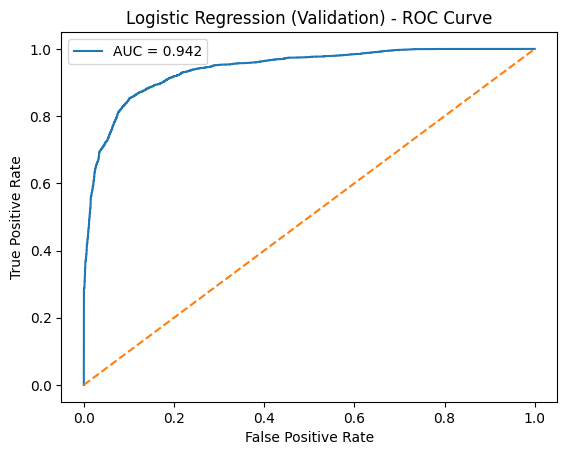

In [26]:
evaluate_model(
    grid_lr.best_estimator_,
    X_val,
    y_val,
    "Logistic Regression (Validation)"
)


Logistic Regression (Test)
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4077
           1       0.88      0.88      0.88      5084

    accuracy                           0.87      9161
   macro avg       0.87      0.87      0.87      9161
weighted avg       0.87      0.87      0.87      9161

ROC-AUC: 0.9386008459885211


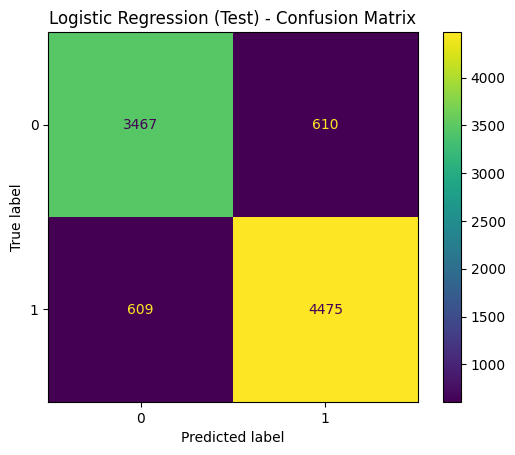

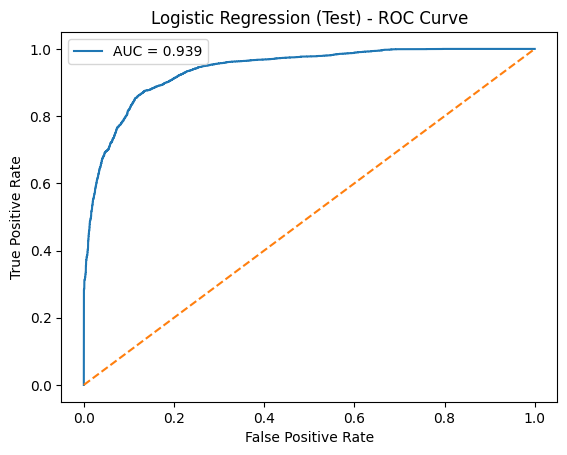

In [27]:
evaluate_model(
    final_lr_pipeline,
    X_test,
    y_test,
    "Logistic Regression (Test)"
)

# Random Forest Training

In [28]:
rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"
    ))
])

rf_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['cap-diameter', 'stem-height', 'stem-width'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handl...
                                                  Index(['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed',
       'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root',
       'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring',
       'ring-type', 'spore-print-color', 'habitat', 'season'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42))])

# Finding best parameters

In [29]:
rf_param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [None, 10, 20],
    "classifier__min_samples_split": [2, 5]
}

grid_rf = GridSearchCV(
    rf_model,
    rf_param_grid,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

print("Best RF Params:", grid_rf.best_params_)

Best RF Params: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}


Random Forest (Validation)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4077
           1       1.00      1.00      1.00      5083

    accuracy                           1.00      9160
   macro avg       1.00      1.00      1.00      9160
weighted avg       1.00      1.00      1.00      9160

ROC-AUC: 1.0


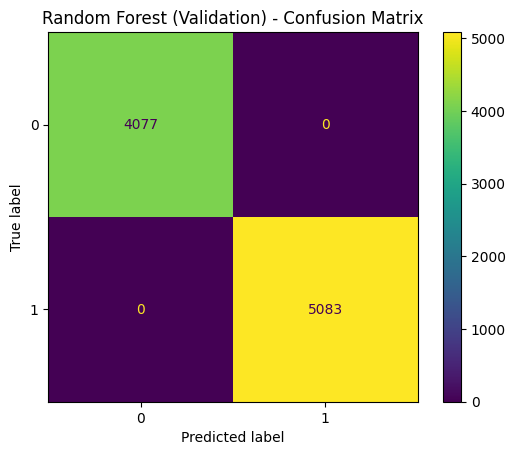

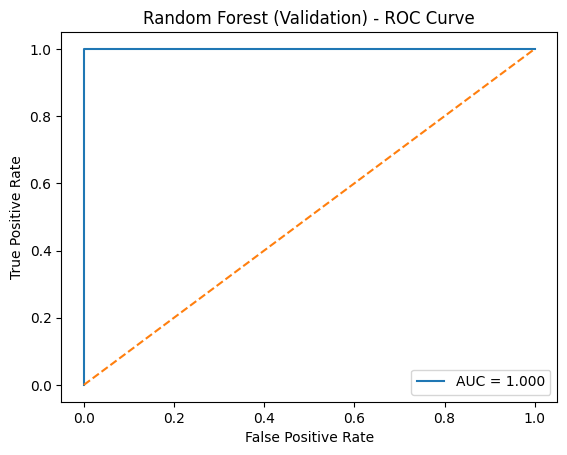

In [30]:
evaluate_model(
    grid_rf.best_estimator_,
    X_val,
    y_val,
    "Random Forest (Validation)"
)

In [34]:
final_rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=100,
        max_depth= None,
        min_samples_split=2,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"
    ))
])

final_rf.fit(X_train_final, y_train_final)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['cap-diameter', 'stem-height', 'stem-width'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handl...
                                                  Index(['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed',
       'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root',
       'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring',
       'ring-type', 'spore-print-color', 'habitat', 'season'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42))])

Random Forest (Test)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4077
           1       1.00      1.00      1.00      5084

    accuracy                           1.00      9161
   macro avg       1.00      1.00      1.00      9161
weighted avg       1.00      1.00      1.00      9161

ROC-AUC: 1.0


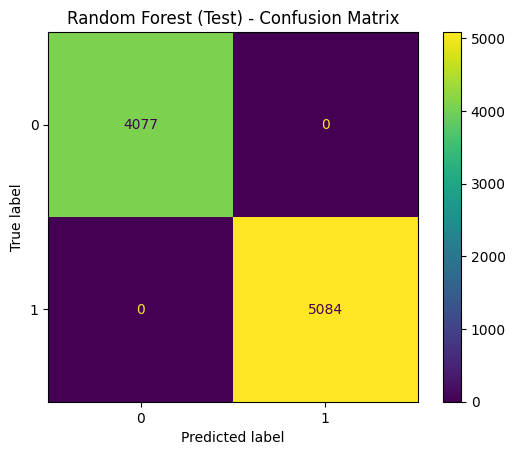

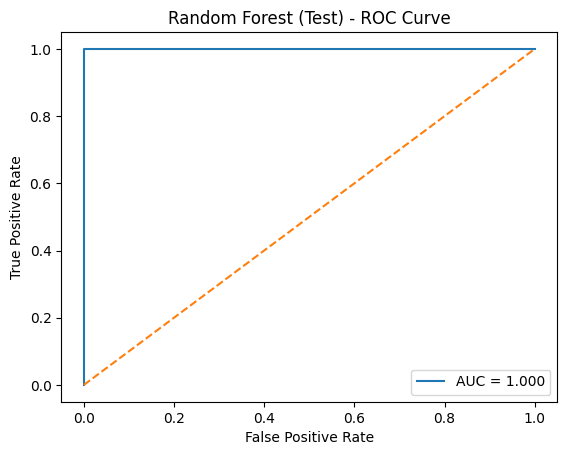

In [35]:
evaluate_model(
    final_rf,
    X_test,
    y_test,
    "Random Forest (Test)"
)


In [43]:
joblib.dump(final_rf, "best_mushroom_random_forest_model.pkl")

['best_mushroom_random_forest_model.pkl']

# XgBoost model training

In [36]:
xgb_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        eval_metric="logloss",
        random_state=42
    ))
])

xgb_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['cap-diameter', 'stem-height', 'stem-width'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handl...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

# Finding best parameters

In [38]:
xgb_param_grid = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [3, 5, 6],
    "classifier__learning_rate": [0.05, 0.1, 0.15]
}

grid_xgb = GridSearchCV(
    xgb_model,
    xgb_param_grid,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1
)

grid_xgb.fit(X_train, y_train)

print("Best XGB Params:", grid_xgb.best_params_)

Best XGB Params: {'classifier__learning_rate': 0.15, 'classifier__max_depth': 6, 'classifier__n_estimators': 300}


XGBoost (Validation)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4077
           1       1.00      1.00      1.00      5083

    accuracy                           1.00      9160
   macro avg       1.00      1.00      1.00      9160
weighted avg       1.00      1.00      1.00      9160

ROC-AUC: 1.0


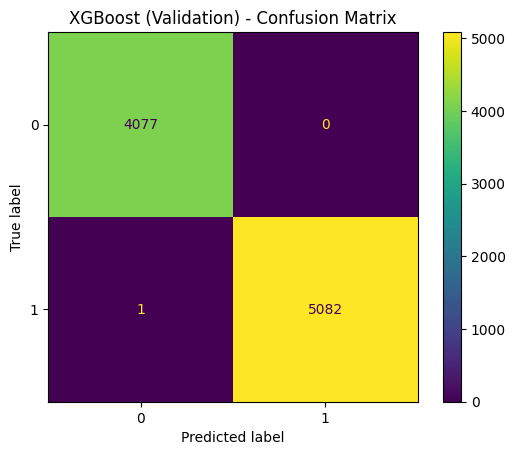

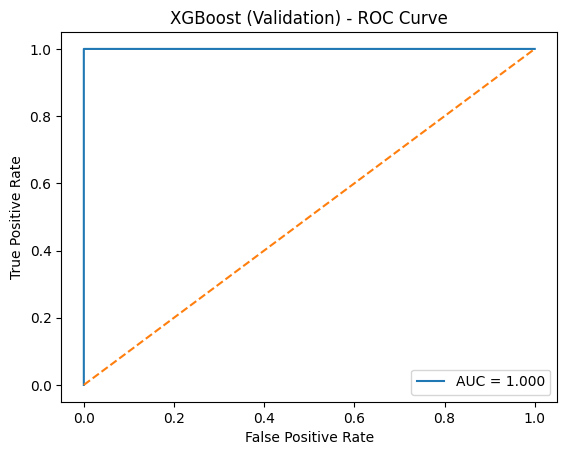

In [39]:
evaluate_model(
    grid_xgb.best_estimator_,
    X_val,
    y_val,
    "XGBoost (Validation)"
)

In [58]:
final_xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.15,
        eval_metric="logloss",
        random_state=42
    ))
])

final_xgb.fit(X_train_final, y_train_final)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['cap-diameter', 'stem-height', 'stem-width'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handl...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.15,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, ...))])

XGBoost (Test)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4077
           1       1.00      1.00      1.00      5084

    accuracy                           1.00      9161
   macro avg       1.00      1.00      1.00      9161
weighted avg       1.00      1.00      1.00      9161

ROC-AUC: 1.0


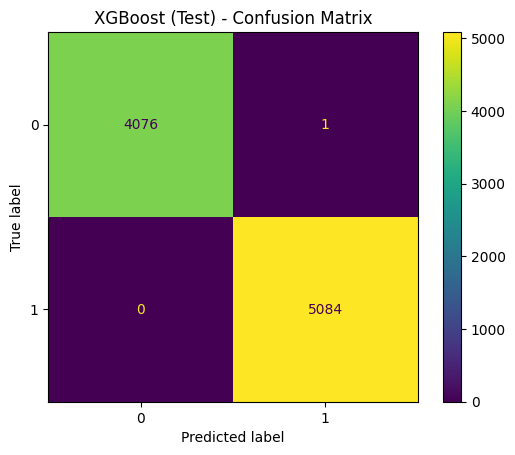

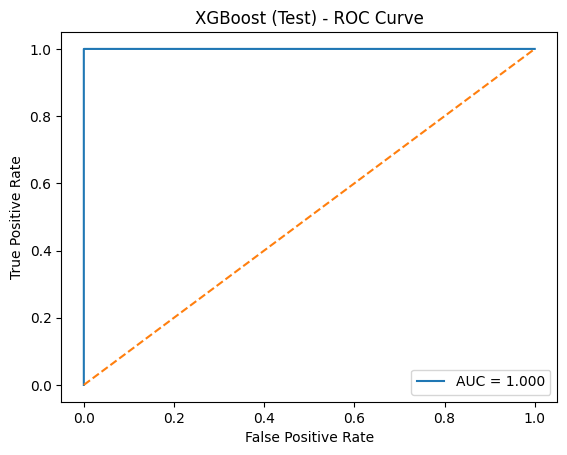

In [41]:
evaluate_model(
    final_xgb,
    X_test,
    y_test,
    "XGBoost (Test)"
)


In [42]:
joblib.dump(final_xgb, "best_mushroom_xgboost_model.pkl")

['best_mushroom_xgboost_model.pkl']

# feature importnace for Random Forest

In [44]:
feature_names = final_rf.named_steps["preprocessor"].get_feature_names_out()
importances = final_rf.named_steps["classifier"].feature_importances_

rf_importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

rf_importance_df.head(15)


,feature,importance
2,num__stem-width,0.081380
1,num__stem-height,0.047981
0,num__cap-diameter,0.046811
86,cat__stem-color_w,0.032570
45,cat__gill-spacing_d,0.022594
44,cat__gill-spacing_c,0.020017
58,cat__gill-color_w,0.019502
71,cat__stem-surface_missing,0.018663
41,cat__gill-attachment_p,0.017768
47,cat__gill-spacing_missing,0.017564


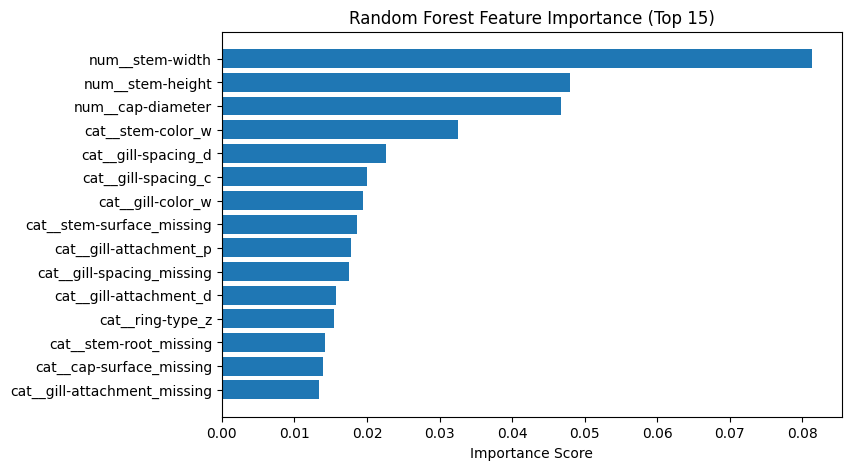

In [45]:
plt.figure(figsize=(8, 5))
plt.barh(
    rf_importance_df["feature"].head(15)[::-1],
    rf_importance_df["importance"].head(15)[::-1]
)
plt.title("Random Forest Feature Importance (Top 15)")
plt.xlabel("Importance Score")
plt.show()


In [49]:
coef = final_lr_pipeline.named_steps["classifier"].coef_[0]
feature_names = final_lr_pipeline.named_steps["preprocessor"].get_feature_names_out()

lr_importance_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coef,
    "abs_coefficient": np.abs(coef)
}).sort_values(by="abs_coefficient", ascending=False)

lr_importance_df.head(15)


,feature,coefficient,abs_coefficient
96,cat__veil-color_y,-22.826722,22.826722
89,cat__veil-type_u,18.166295,18.166295
107,cat__ring-type_z,17.450551,17.450551
109,cat__spore-print-color_k,15.982875,15.982875
95,cat__veil-color_w,-15.215532,15.215532
61,cat__stem-root_c,13.070439,13.070439
67,cat__stem-surface_g,11.881067,11.881067
64,cat__stem-root_r,11.834137,11.834137
103,cat__ring-type_m,-11.039196,11.039196
68,cat__stem-surface_h,9.517369,9.517369
